In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import emcee

from question_3 import UniformPrior, Likelihood, LogProb, AutocorrelationTime, Template
from data_loader import Data

In [2]:
filepath = 'simple-cw-master/'
filename = 'cw_' + 'example' + '.csv'

data = Data(filepath + filename)

In [3]:
ndim = 2
nwalkers = 4
steps = 10000
# (epsilon, fdot): true value for epsilon is 1e-6, true value for fdot is 1e-4
prior_lower_bounds = (0.9e-6, 0.9e-4)
prior_upper_bounds = (1.1e-6, 1.1e-4)

# prior_lower_bounds = (0, 0)
# prior_upper_bounds = (1e-4, 1e-3)

In [4]:
prior = UniformPrior(lower_bounds=prior_lower_bounds, upper_bounds=prior_upper_bounds) # initialize the prior, which is uniform (1 in allowed region, 0 otherwise)
likelihood = Likelihood() # initialize likelihood function
log_prob = LogProb(likelihood=likelihood, prior=prior) # pass likelihood function and prior into log_probability, where log_prob = log_likelihood + log_prior

In [5]:
p0 = np.random.uniform(size=(nwalkers, ndim), low=prior_lower_bounds, high=prior_upper_bounds) # random initial guesses, using the same bounds as the prior

In [6]:
dtype=[('log_like', float)]
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_prob, args=[data.times, data.signal, data.f_rot0], blobs_dtype=dtype) # initialize MCMC sampler

In [7]:
sampler.run_mcmc(p0, steps, progress=True) # run MCMC sampler

  0%|                                                                                        | 0/10000 [00:00<?, ?it/s]D:\OneDrive - University of Toronto\CITA\CITA_mini_project\question_3.py:73: RuntimeWarning: divide by zero encountered in log
  log_prior = np.log(self.prior((self.epsilon_guess, self.df_dt_guess)))
100%|███████████████████████████████████████████████████████████████████████████| 10000/10000 [01:08<00:00, 147.04it/s]


State([[1.04920474e-06 9.48596536e-05]
 [1.01867113e-06 9.87663211e-05]
 [1.04613970e-06 1.06853237e-04]
 [1.09688119e-06 1.04435930e-04]], log_prob=[-83.75921657 -84.1501418  -83.81612295 -83.11525815], blobs=[(-83.75921657,) (-84.1501418 ,) (-83.81612295,) (-83.11525815,)], random_state=('MT19937', array([ 175622937,  375233846, 2767296613, 2934892766, 1905721223,
       1607923397, 2019378458, 3498156541, 3213714381,  144956693,
       3167220502, 4283121358, 3158936427, 2069331812, 1329241430,
        424627045,  548754200, 1145357160, 2061153971, 2551155771,
       1059488158, 4199852475, 2483407668, 1961809662, 4291874430,
       2264540416,  923097590, 1740790588, 2486253089, 1229823109,
       3967771282,  913763531, 1875212871,  916469450,  541514302,
       3006071270, 3658638602, 2795537933, 1660375271, 3817891212,
       1576839616, 2258594249, 3460520978,  390952598,  852111970,
       1138221369, 3252794019, 2012761706,  136314236,  208455139,
        455774323, 418873351

In [18]:
print(sampler.get_autocorr_time())

autocorrelation_time = int(np.ceil(np.max(sampler.get_autocorr_time())))

print(autocorrelation_time)

[59.69620332 71.4809028 ]
72


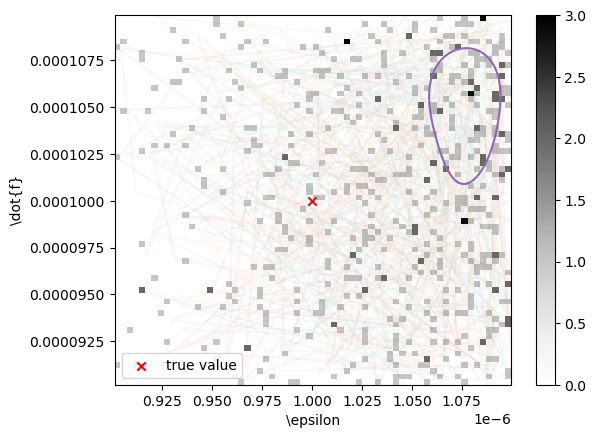

In [19]:
flat_samples = sampler.get_chain(flat=True) # get flattened samples for plotting histograms
samples = sampler.get_chain() # get samples for plotting individual chains

epsilon_points = flat_samples[:, 0][::autocorrelation_time]
df_dt_points = flat_samples[:, 1][::autocorrelation_time]

epsilon_walk = samples[:, :, 0][::autocorrelation_time]
df_dt_walk = samples[:, :, 1][::autocorrelation_time]

plt.figure() # plot histogram, contour plot, and chains all overlaid, with true value incidated

plt.plot(epsilon_walk, df_dt_walk, alpha=0.05)
sns.kdeplot(x=epsilon_points, y=df_dt_points, levels=[0.9])
plt.hist2d(x=epsilon_points, y=df_dt_points, bins=64, cmap='Greys')
plt.colorbar()

plt.scatter([1e-6], [1e-4], label='true value', color='red', marker='x')
plt.legend()

plt.xlabel(r'\epsilon')
plt.ylabel(r'\dot{f}')

plt.show()

chain 0 (epsilon, fdot): 1.049204744435388e-06 9.485965357631749e-05
chain 1 (epsilon, fdot): 1.0186711304463107e-06 9.87663210867714e-05
chain 2 (epsilon, fdot): 1.0461397019361166e-06 0.0001068532366591317
chain 3 (epsilon, fdot): 1.0968811901885031e-06 0.00010443593042522086


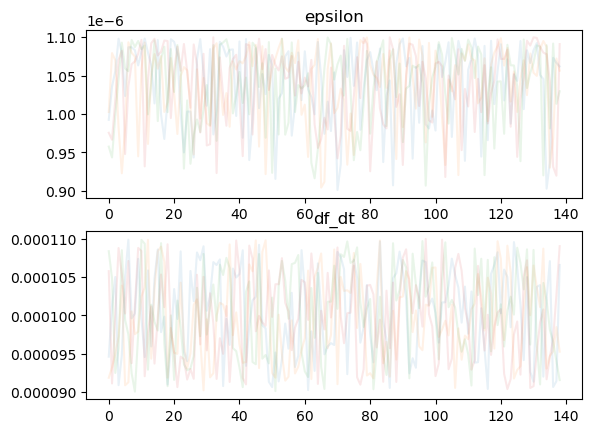

In [26]:
samples = np.swapaxes(samples, 0, 1)

fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1) # trace plots for each parameter

for i, chain in enumerate(samples):
    ax1.plot(chain.T[0][::autocorrelation_time], alpha=0.1)
    ax2.plot(chain.T[1][::autocorrelation_time], alpha=0.1)

    print('chain %i (epsilon, fdot):' %i, chain.T[0, -1], chain.T[1, -1])

ax1.set_title('epsilon')
ax2.set_title('df_dt')
plt.show()

In [27]:
blobs = sampler.get_blobs()
log_likelihoods = np.swapaxes(blobs['log_like'], 0, 1)
print(log_likelihoods)
print('------------------------------------------------------------------------------------------')
print(samples)

[[-84.52369775 -84.52369775 -84.47130401 ... -83.79993343 -83.79993343
  -83.75921657]
 [-84.41492694 -84.41492694 -84.42136129 ... -84.08624623 -84.1501418
  -84.1501418 ]
 [-85.02345632 -84.74666467 -84.79498082 ... -84.05403628 -83.76808025
  -83.81612295]
 [-84.75330968 -84.75330968 -84.76225756 ... -83.11525815 -83.11525815
  -83.11525815]]
------------------------------------------------------------------------------------------
[[[9.92493753e-07 9.46128158e-05]
  [9.92493753e-07 9.46128158e-05]
  [9.97246665e-07 9.33257182e-05]
  ...
  [1.05043246e-06 9.00555830e-05]
  [1.05043246e-06 9.00555830e-05]
  [1.04920474e-06 9.48596536e-05]]

 [[1.00264941e-06 9.18626443e-05]
  [1.00264941e-06 9.18626443e-05]
  [1.00201589e-06 9.20342037e-05]
  ...
  [1.02372457e-06 9.73803834e-05]
  [1.01867113e-06 9.87663211e-05]
  [1.01867113e-06 9.87663211e-05]]

 [[9.57626151e-07 1.08369669e-04]
  [9.74621846e-07 1.02138482e-04]
  [9.71417806e-07 1.03386512e-04]
  ...
  [1.02583147e-06 1.01413873e

In [12]:
check_chain = samples[-1]
check_epsilon = chain.T[0, -1]
check_df_dt = chain.T[1, -1]

check_template = Template(epsilon=check_epsilon, df_dt=check_df_dt, f_rot0=data.f_rot0)
check_model = check_template(data.times)
likelihood = Likelihood()
check_likelihood = np.log(likelihood(check_model, data.signal))
print('likelihood for params (epsilon, fdot) = (%f, %f) is %f' %(check_epsilon, check_df_dt, check_likelihood))

likelihood for params (epsilon, fdot) = (0.000001, 0.000104) is -83.115258
